# Preparation

In [ ]:
"""Uncomment if necessary to install libraries"""

"""
!pip install requests
!pip install BeautifulSoup
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install math
!pip install geopy
!pip install sklearn
!pip install ahpy
!pip install warnings
"""

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
from math import radians, sin, cos, sqrt, atan2
from geopy.geocoders import OpenCage
from sklearn.preprocessing import MinMaxScaler
from ahpy import Compare

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Dataset Compilation

In [2]:
def scrape_zip_codes(url):
    zip_codes = []
    land_areas = []
    
    response = requests.get(url)
    if response.status_code != 200:
        print("Error: Failed to retrieve the page.")
        return
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the <table> tag
    table = soup.find('table')
    # Find all <tr> tags in the <tbody> section
    tbody = table.find('tbody')
    rows = tbody.find_all('tr')
    
    # Extract the required data from each row
    for row in rows:
        # Find all <td> tags in the current row
        cells = row.find_all('td')
        # Extract the value enclosed between <a> and </a> tags in the first <td>
        anchor_tag = cells[0].find('a')
        # Append the zip code value to a corresponding array
        zip_codes.append(anchor_tag.text)
        # Append the land area value to a corresponding array
        land_areas.append(int(cells[1].text.replace(',', '')))
        
    return zip_codes, land_areas

In [3]:
zip_codes, land_areas = scrape_zip_codes("https://namecensus.com/zip-codes/new-york/city/new-york/")
# Make sure the quantity of entries retrieved for each variable matches
assert len(zip_codes) == len(land_areas)
print(f"Number of zip codes in New York city: {len(zip_codes)}")

Number of zip codes in New York city: 214


In [4]:
zip_codes_str = ",".join(zip_codes)
census_response_tableDP05 = requests.get(f"https://api.census.gov/data/2021/acs/acs5/profile?get=group(DP05)" \
                                         f"&for=zip%20code%20tabulation%20area:{zip_codes_str}").json()

area_population = []
tj_target_audience = []
zip_code_tabulation_areas_tableDP05 = []

for i in range(1, len(census_response_tableDP05)):
    # 'DP05_0001E': Estimate!!SEX AND AGE!!Total population
    area_population.append(int(census_response_tableDP05[i][0]))
    # Since TJ's target audience is the range of individuals from 20 to 45, I added values from multiple 
    # columns in the Census Bureau data that is broken down by smaller ranges (20-24 + 25-34 + 35-44).
    
    # 'DP05_0009E': Estimate!!SEX AND AGE!!Total population!!20 to 24 years
    # 'DP05_0010E': Estimate!!SEX AND AGE!!Total population!!25 to 34 years
    # 'DP05_0011E': Estimate!!SEX AND AGE!!Total population!!35 to 44 years
    tj_target_audience.append(sum([int(census_response_tableDP05[i][64]), 
                                   int(census_response_tableDP05[i][72]),
                                   int(census_response_tableDP05[i][80])]))
    # 'zip code tabulation area'
    zip_code_tabulation_areas_tableDP05.append(census_response_tableDP05[i][-1])

# Check if US Census Bureau API provides data about all NYC zip codes. If not, 
# remove the zip codes that were not found as a result of the API call
if len(zip_code_tabulation_areas_tableDP05) != len(zip_codes):
    missing = set(zip_codes) - set(zip_code_tabulation_areas_tableDP05)
    print(f"Data for the following zip code areas was not found: {missing}")

    for code in missing:
        idx = zip_codes.index(code)
        zip_codes.pop(idx)
        land_areas.pop(idx)

# Make sure the order and the content of the scraped zip codes is the same as the content from US Census Bureau API
assert zip_codes == zip_code_tabulation_areas_tableDP05

Data for the following zip code areas was not found: {'11351', '11425'}


In [5]:
zip_codes_str = ",".join(zip_codes)
census_response_tableB19013 = requests.get(f"https://api.census.gov/data/2021/acs/acs5?get=NAME,group(B19013)" \
                                           f"&for=zip%20code%20tabulation%20area:{zip_codes_str}").json()
zip_code_tabulation_areas_tableB19013 = []
median_household_income = []

for i in range(1, len(census_response_tableB19013)):
    # 'B19013_001E': Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars)
    median_household_income.append(int(census_response_tableB19013[i][1]))
    # 'zip code tabulation area'
    zip_code_tabulation_areas_tableB19013.append(census_response_tableB19013[i][7])
    
# Make sure the order and the content of the scraped zip codes is the same as the content from US Census Bureau API
assert zip_codes == zip_code_tabulation_areas_tableB19013

In [6]:
metrics = pd.DataFrame({"Zip Code": zip_codes, "Land Area": land_areas, 
                        "Population": area_population,
                        "Trader Joe's Target Audience": tj_target_audience, 
                        "Median Household Income": median_household_income})
# Remove rows with any value less than or equal to 0.
# According to my preliminary examination of the obtained data, unpopulated
# areas have 0 in the "Population column" and -666666 in other columns).
metrics = metrics[(metrics.iloc[:, 1:] >= 0).all(axis=1)]
metrics.index = range(1, metrics.shape[0]+1)

print(f"Number of zip code areas in NYC that are populated and " \
      f"possess necessary demographic data: {metrics.shape[0]}")

Number of zip code areas in NYC that are populated and possess necessary demographic data: 182


# Exploratory Data Analysis

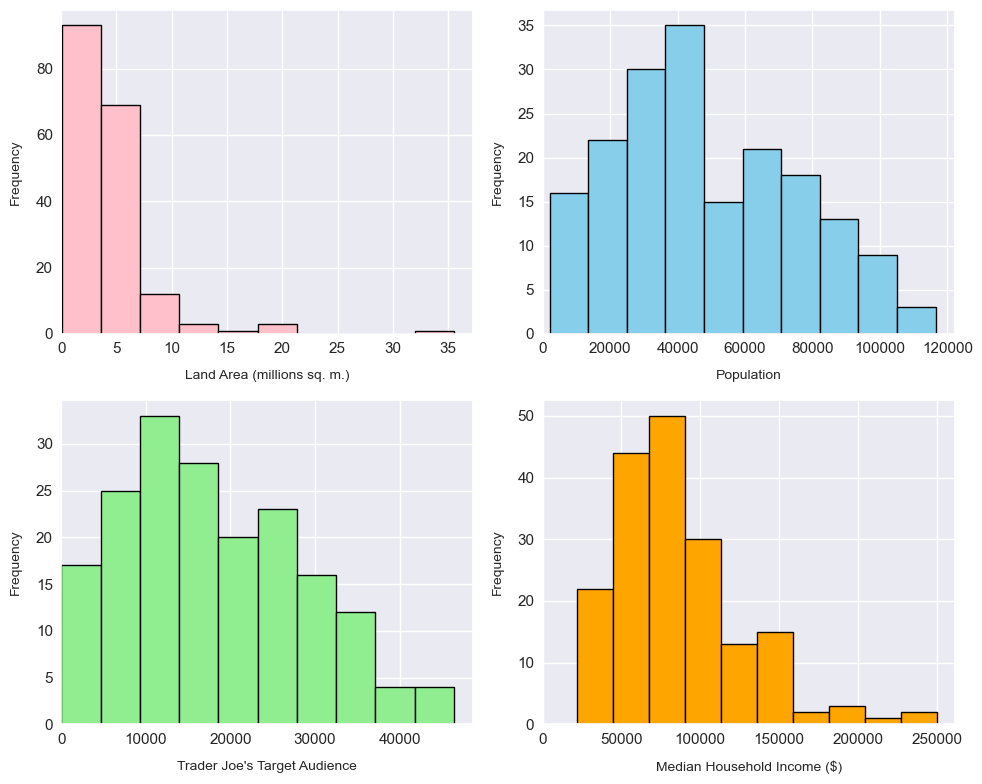

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
colors = ['skyblue', 'lightgreen', 'orange', 'pink']

# Create histograms for each column (excluding the first one)
for i, column in enumerate(metrics.columns[1:]):
    # Select the corresponding subplot
    ax = axs[i // 2][i % 2]  
    ax.hist(metrics[column], edgecolor='black', color=colors[i-1])
    ax.set_xlabel(column, fontsize=10, labelpad=10)
    ax.set_ylabel('Frequency', fontsize=10, labelpad=10)
    
    if i == 0:  
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e6)}'))
        ax.set_xlabel(f"{column} (millions sq. m.)", fontsize=10, labelpad=10)
    elif i == 3:
        ax.set_xlabel(f"{column} ($)", fontsize=10, labelpad=10)
    
    # Style subplot tickers and lower limit of x-axis
    ax.xaxis.set_tick_params(width=0.5, size=2.5, color='black', pad=4)
    ax.yaxis.set_tick_params(width=0.5, size=2.5, color='black', pad=4)
    ax.tick_params(axis='both', which='both', length=4, direction='inout')
    ax.set_xlim(left=0) 

plt.tight_layout()
plt.show()

In [8]:
print(f"Smallest NYC zip code: {min(zip_codes)}\nLargest NYC zip code: {max(zip_codes)}")

Smallest NYC zip code: 10001
Largest NYC zip code: 11697


# Foot Traffic 

In [9]:
zip_centroids = pd.read_csv("zip_code_centroids.csv")
# Drop values that are not in the range specified in the cell above
zip_centroids = zip_centroids.drop(zip_centroids[(zip_centroids["STD_ZIP5"] < 10001) | \
                                                 (zip_centroids["STD_ZIP5"] > 11697)].index)
zip_centroids["STD_ZIP5"] = zip_centroids["STD_ZIP5"].astype(str)
# Eliminate zip codes that are within the specified range but were filtered out earlier
zip_centroids = zip_centroids[zip_centroids["STD_ZIP5"].isin(list(metrics["Zip Code"]))]
# Make sure the the number of zip code centroids matches the number of zip codes in the "metrics" dataset
assert len(zip_centroids["STD_ZIP5"]) == len(metrics["Zip Code"])

In [10]:
zip_centroids = zip_centroids.drop(columns=set(zip_centroids.columns) - set(["STD_ZIP5", 
                                                                             "LATITUDE", 
                                                                             "LONGITUDE"]))
zip_centroids.columns = ["Zip Code", "Latitude", "Longitude"]
zip_centroids.index = range(zip_centroids.shape[0])

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine distance formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    # Earth's radius in kilometers
    distance = 6371 * c  
    return distance

In [12]:
# Apply the function above to find the closest neighbors
for i, zip_code in enumerate(zip_centroids["Zip Code"]):
    distances = zip_centroids.apply(
        lambda row: haversine_distance(
            row["Latitude"],
            row["Longitude"],
            zip_centroids.loc[zip_centroids["Zip Code"] == zip_code, "Latitude"].iloc[0],
            zip_centroids.loc[zip_centroids["Zip Code"] == zip_code, "Longitude"].iloc[0],
        ),
        axis=1
    )

    closest_zip_codes = distances.sort_values().index.tolist()
    # Remove the current zip code from the list of closest zip codes
    closest_zip_codes.remove(i)  

    for j, closest_zip_code in enumerate(closest_zip_codes):
        zip_centroids.at[i, f"Closest {j+1}"] = zip_centroids.at[closest_zip_code, "Zip Code"]

In [13]:
foot_traffic = pd.read_csv("foot_traffic.csv")
# Leave the most recent measurements (dated October 2022)
foot_traffic = foot_traffic[["the_geom", "Oct22_AM", "Oct22_PM", "Oct22_MD"]]
# https://www.nyc.gov/html/dot/downloads/pdf/bi-annual-ped-count-readme.pdf
foot_traffic.columns = ["Geolocation", "AM count", "PM count", "Midday Weekend Count"]
# Break the "POINT(x,y)" representation into separate Longitude and Latitude columns
foot_traffic[['Longitude', 'Latitude']] = foot_traffic['Geolocation'].str.strip('POINT ()' \
                                                                               ).str.split(expand=True \
                                                                                          ).astype(float)
foot_traffic = foot_traffic.drop(["Geolocation"], axis=1)
# Drop "ND" values from the dataset (4 rows)
foot_traffic = foot_traffic[~(foot_traffic == "ND").any(axis=1)]
foot_traffic["AM count"] = foot_traffic["AM count"].astype(int)
foot_traffic["PM count"] = foot_traffic["PM count"].astype(int)
foot_traffic["Midday Weekend Count"] = foot_traffic["Midday Weekend Count"].astype(int)
# Take an average of the foot traffic measurements
foot_traffic["Average Foot Traffic"] = foot_traffic[["AM count", "PM count", \
                                                     "Midday Weekend Count"]].mean(axis=1).astype(int)
foot_traffic = foot_traffic.drop(["AM count", "PM count", "Midday Weekend Count"], axis=1)
foot_traffic.index = range(foot_traffic.shape[0])

In [14]:
# free trial, which allows up to 2,500 API requests/day
# https://opencagedata.com/tutorials/geocode-in-python
geolocator = OpenCage(api_key="[PASTE YOUR OWN API KEY HERE]")

# Convert the Latitude, Longitude coordinates into a zip code for each location
def reverse_geocode(row):
    try:
        location = geolocator.reverse((row["Latitude"], row["Longitude"]), exactly_one=True)
        return location.raw["components"]["postcode"]
    except Exception as e:
        print(f"Error: {e}")
        raise

foot_traffic["Zip Code"] = foot_traffic.apply(reverse_geocode, axis=1)

In [15]:
foot_traffic = foot_traffic.drop(["Longitude", "Latitude"], axis=1)
# Since there might be multiple measurements done within a single zip code area,
# I have grouped the dataset by the "Zip Code" column and averaged the foot traffic
foot_traffic = foot_traffic.groupby("Zip Code")["Average Foot Traffic"].mean().reset_index()
foot_traffic["Average Foot Traffic"] = foot_traffic["Average Foot Traffic"].astype(int)

In [16]:
foot_traffic_values = []
directly_found = 0
averaged = 0

# Iterate over each row in the metrics dataset
for _, row in metrics.iterrows():
    # Retrieve the corresponding zip code
    zip_code = row["Zip Code"]
    
    # Check if the zip code exists in the foot_traffic dataset
    if zip_code in foot_traffic["Zip Code"].values:
        # If foot traffic data exists, retrieve the value
        foot_traffic_value = foot_traffic.loc[foot_traffic["Zip Code"] == zip_code, "Average Foot Traffic"].values[0]
        directly_found += 1
    
    else:
        # If foot traffic data is not available, find the closest neighbors from centroids dataset
        closest_neighbors = zip_centroids.loc[zip_centroids["Zip Code"] == zip_code]
        averaged += 1
        
        valid_neighbors = []
        j = 1
        
        # Iterate through the closest neighbors and check if foot traffic data exists
        while len(valid_neighbors) < 5:
            neighbor = closest_neighbors[f"Closest {j}"].values[0]
            
            if neighbor in foot_traffic["Zip Code"].values:
                neighbor_foot_traffic = foot_traffic.loc[foot_traffic["Zip Code"] == neighbor, \
                                                         "Average Foot Traffic"].values[0]
                valid_neighbors.append(neighbor_foot_traffic)
            
            j += 1
        
        # Once 5 valid neighbors are found, apply inverse distance weighting
        if len(valid_neighbors) == 5:
            weights = [1/distance for distance in range(1, len(valid_neighbors) + 1)]
            weighted_average = np.average(valid_neighbors, weights=weights)
            foot_traffic_value = weighted_average
        else:
            print("Error! 5 neighbors were not found!")
    
    # Append the foot traffic value to the list
    foot_traffic_values.append(int(foot_traffic_value))

metrics["Foot Traffic"] = foot_traffic_values
print(f"Foot traffic data was directly available for {directly_found} zip code areas. \n"
      f"Inverse distance weighting was applied for {averaged} zip code areas.")

Foot traffic data was directly available for 68 zip code areas. 
Inverse distance weighting was applied for 114 zip code areas.


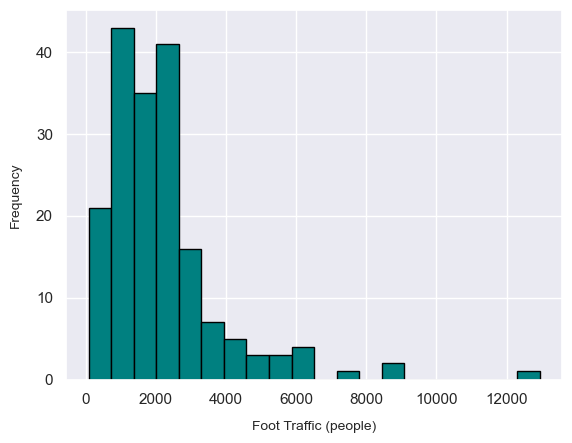

In [17]:
plt.hist(metrics["Foot Traffic"], bins=20, edgecolor='black', color='teal')
plt.xlabel('Foot Traffic (people)', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.show()

# Store Locations

In [18]:
# https://locations.traderjoes.com/ny/brooklyn/
# https://locations.traderjoes.com/ny/new-york/
# https://locations.traderjoes.com/ny/queens/
# https://locations.traderjoes.com/ny/staten-island/
trader_joes_nyc_zip_codes = [11201, 11201, 10023, 10010, 10009, 10002, 10016, 10013,
                             10003, 10022, 10025, 11375, 11101, 11374, 10314]

# https://www.target.com/store-locator/store-directory/new-york
target_nyc_zip_codes = [10463, 10451, 10465, 10458, 11239, 11217, 11210, 11229, 11204, 
                        11234, 11214, 11226, 11201, 11354, 11375, 11432, 11101, 10035,
                        10007, 10009, 10036, 10002, 10021, 10016, 10033, 10023, 10036,
                        10028, 10025, 10012, 10309, 10314, 10302]
# Super long link for no reason so I did not paste it here. However, you can find it
# by searching "Whole Foods locations" and then choosing New York
whole_foods_nyc_zip_codes = [10005, 10007, 10002, 10003, 10001, 10016, 10001, 10036,
                             10022, 10019, 10128, 10025, 10027, 11215, 11217]

def verify_zip_code(zip_code):
    return str(zip_code) in metrics["Zip Code"].values

# Double-check that manually sourced zip codes of Trader Joe's, Target, and Whole Foods 
# are present among the zip codes in the "metrics" dataset
for tj in trader_joes_nyc_zip_codes:
    if not verify_zip_code(tj):
        print(f"Trader Joe's with zip code {tj} is not among the selected zip code areas!")
        
for t in target_nyc_zip_codes:
    if not verify_zip_code(t):
        print(f"Target with zip code {t} is not among the selected zip code areas!")
        
for wf in whole_foods_nyc_zip_codes:
    if not verify_zip_code(wf):
        print(f"Trader Joe's with zip code {wf} is not among the selected zip code areas!")

In [19]:
# Default value for the column is 0 
# (will be modified later if a Trader Joe's store is found in the given zip code area)
metrics["Trader Joe's"] = 0

# Default value for the column is 0 
# (will be modified later if either a Target or a Whole Foods store is located in the given zip code area)
metrics["Competitors"] = 0

for tj_zip_code in trader_joes_nyc_zip_codes:
    metrics.loc[metrics["Zip Code"] == str(tj_zip_code), "Trader Joe's"] += 1

for t_zip_code in target_nyc_zip_codes:
    metrics.loc[metrics["Zip Code"] == str(t_zip_code), "Competitors"] += 1

for wf_zip_code in whole_foods_nyc_zip_codes:
    metrics.loc[metrics["Zip Code"] == str(wf_zip_code), "Competitors"] += 1

In [20]:
styled_metrics = metrics.style
# Hide the index
styled_metrics.hide(axis="index")
# Define a formatting function to center-align the column names and cells
def center_style(row):
    return ["text-align: center"] * len(row)
# Apply center alignment to all cells
styled_metrics = styled_metrics.set_table_styles([{"selector": "th",
                                         "props": [("text-align", "center")]}])
styled_metrics = styled_metrics.apply(center_style, axis=0)

styled_metrics

Zip Code,Land Area,Population,Trader Joe's Target Audience,Median Household Income,Foot Traffic,Trader Joe's,Competitors
10001,1609400,26966,13812,101409,12938,0,2
10002,2277670,76807,28151,37093,2446,1,2
10003,1493000,54447,26281,137533,4596,1,1
10004,1449740,4795,2182,216017,2436,0,0
10005,190416,8637,6114,197188,4637,0,1
10006,237784,3894,2451,200536,1457,0,0
10007,423358,8194,3993,250001,4426,0,2
10009,1596980,60000,28627,77551,5369,1,1
10010,1011820,33193,15023,131635,6281,1,0
10011,1705240,51867,21547,139343,8820,0,0


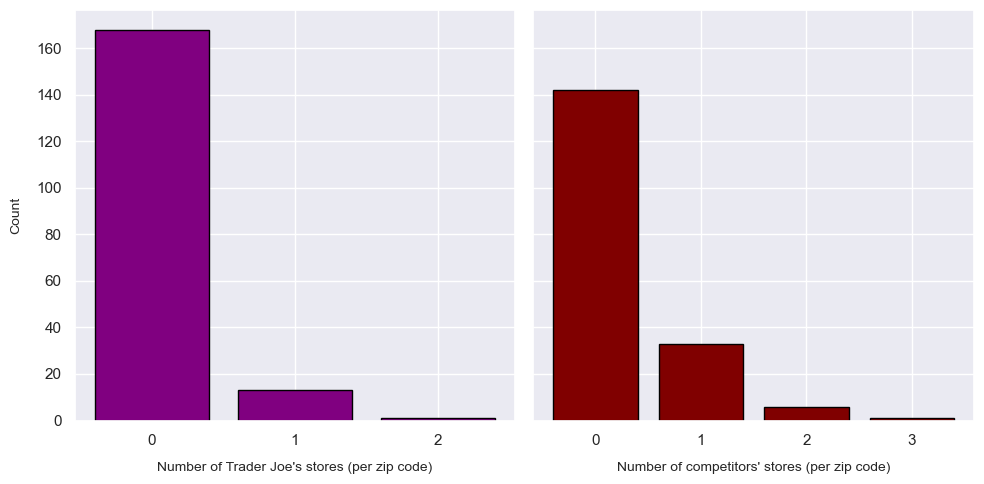

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax1.bar(metrics["Trader Joe's"].value_counts().index, metrics["Trader Joe's"].value_counts(),  
        edgecolor="black", color="purple")
ax1.set_xticks([0, 1, 2])
ax1.set_xlabel("Number of Trader Joe's stores (per zip code)", fontsize=10, labelpad=10)
ax1.set_ylabel("Count", fontsize=10, labelpad=10)

ax2.bar(metrics["Competitors"].value_counts().index, metrics["Competitors"].value_counts(), 
        edgecolor="black", color="maroon")
ax2.set_xticks([0, 1, 2, 3])
ax2.set_xlabel("Number of competitors' stores (per zip code)", fontsize=10, labelpad=10)

plt.tight_layout()
plt.show()

# Data Normalization

In [22]:
normalized_metrics = metrics.copy()
# Multiply the "Trader Joe's" column by -1 to "punish" the zip code areas
# that already have 1 or more Trader Joe's stores
normalized_metrics["Trader Joe's"] = normalized_metrics["Trader Joe's"] * -1
# Initialize a feature scaling instance
scaler = MinMaxScaler()
# Ensure that all columns besides "Zip Code" are on the same scale and have comparable ranges
normalized_metrics[normalized_metrics.columns[1:]] = scaler.fit_transform(normalized_metrics[normalized_metrics.columns[1:]])

In [23]:
styled_metrics = normalized_metrics.style
# Hide the index
styled_metrics.hide(axis="index")

# Apply center alignment to all cells
styled_metrics = styled_metrics.set_table_styles([{"selector": "th",
                                         "props": [("text-align", "center")]}])
styled_metrics = styled_metrics.apply(center_style, axis=0)

styled_metrics

Zip Code,Land Area,Population,Trader Joe's Target Audience,Median Household Income,Foot Traffic,Trader Joe's,Competitors
10001,0.044517,0.217590,0.297513,0.348723,1.000000,1.000000,0.666667
10002,0.063346,0.653286,0.606490,0.066827,0.183629,0.500000,0.666667
10003,0.041237,0.457821,0.566195,0.507054,0.350918,0.500000,0.333333
10004,0.040018,0.023777,0.046910,0.851049,0.182851,1.000000,0.000000
10005,0.004536,0.057363,0.131637,0.768521,0.354108,1.000000,0.333333
10006,0.005870,0.015901,0.052706,0.783196,0.106676,1.000000,0.000000
10007,0.011099,0.053491,0.085933,1.000000,0.337691,1.000000,0.666667
10009,0.044167,0.506364,0.616747,0.244154,0.411064,0.500000,0.333333
10010,0.027679,0.272025,0.323608,0.481204,0.482026,0.500000,0.000000
10011,0.047217,0.435268,0.464187,0.514988,0.679583,1.000000,0.000000


# Weight Assignment

In [24]:
weights = {"Land Area": 0.13285, "Population": 0.13285, 
           "Trader Joe's Target Audience": 0.15285, "Median Household Income": 0.16285, 
           "Trader Joe's": 0.14285, "Foot Traffic": 0.13285, "Competitors": 0.14285}

# Model Scores

In [25]:
# Create a new column to store the scores
metrics["Score"] = 0
# Iterate through the dataset and calculate the score for each zip code
for index, row in normalized_metrics.iterrows():
    score = sum(row[column] * weight for column, weight in weights.items())
    metrics.at[index, "Score"] = round(score,3)

In [26]:
sorted_metrics = metrics.sort_values(by="Score", ascending=False)
sorted_metrics.index = range(1, sorted_metrics.shape[0]+1)
top_5 = sorted_metrics.head(5).copy()

In [27]:
styled_metrics = top_5.style

# Apply center alignment to all cells
styled_metrics = styled_metrics.set_table_styles([{"selector": "th",
                                         "props": [("text-align", "center")]}])
styled_metrics = styled_metrics.apply(center_style, axis=0)

styled_metrics

,Zip Code,Land Area,Population,Trader Joe's Target Audience,Median Household Income,Foot Traffic,Trader Joe's,Competitors,Score
1,11215,5641350,73419,31107,156930,2789,0,1,0.521000
2,11234,19547800,94254,27707,86185,1231,0,1,0.520000
3,10016,1378330,56758,33257,136431,8572,1,2,0.514000
4,11226,3339500,99776,42717,66173,2075,0,1,0.509000
5,10001,1609400,26966,13812,101409,12938,0,2,0.508000


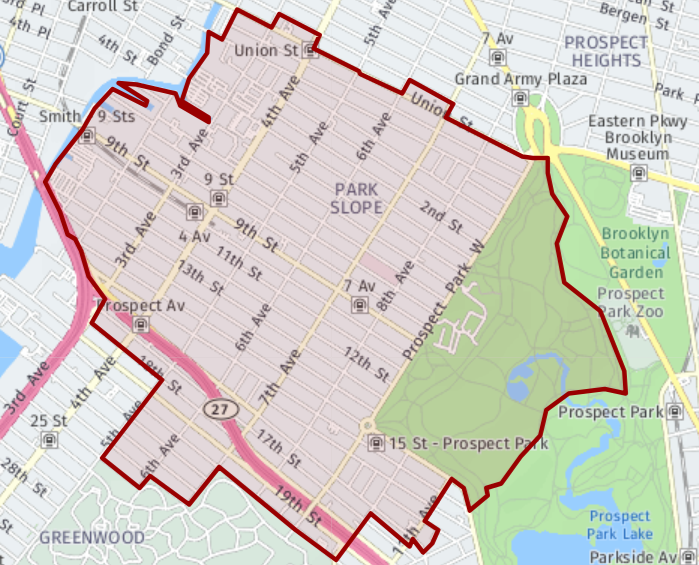

# Average NYC Trader Joe's data

In [28]:
# Compare the model results with the average data from locations that have at least
# one Trader Joe's store
existing_tjs = metrics[metrics["Trader Joe's"] >= 1]
existing_tjs = existing_tjs.drop(["Zip Code", "Score"], axis=1)
existing_tj_avg = existing_tjs.mean()
existing_tj_avg = pd.DataFrame(existing_tj_avg).transpose().astype(int)

In [29]:
styled_metrics = existing_tj_avg.style
# Hide the index
styled_metrics.hide(axis="index")
# Apply center alignment to all cells
styled_metrics = styled_metrics.set_table_styles([{"selector": "th",
                                         "props": [("text-align", "center")]}])
styled_metrics = styled_metrics.apply(center_style, axis=0)

styled_metrics

Land Area,Population,Trader Joe's Target Audience,Median Household Income,Foot Traffic,Trader Joe's,Competitors
4789968,59020,24211,112210,3368,1,1


# Average data across NYC zip code areas

In [30]:
# Compare the model results with the average data from zip code areas across NYC
nyc_zip_codes = metrics.copy()
nyc_zip_codes = nyc_zip_codes.drop(["Zip Code", "Score"], axis=1)
nyc_zip_codes_avg = nyc_zip_codes.mean()
nyc_zip_codes_avg = pd.DataFrame(nyc_zip_codes_avg).transpose().astype(int)

In [31]:
styled_metrics = nyc_zip_codes_avg.style
# Hide the index
styled_metrics.hide(axis="index")
# Apply center alignment to all cells
styled_metrics = styled_metrics.set_table_styles([{"selector": "th",
                                         "props": [("text-align", "center")]}])
styled_metrics = styled_metrics.apply(center_style, axis=0)

styled_metrics

Land Area,Population,Trader Joe's Target Audience,Median Household Income,Foot Traffic,Trader Joe's,Competitors
4201310,48354,17986,86136,2174,0,0
